# Experiment: Comparing different devices for training

In [1]:
using Revise, QARBoM, DWave, DataFrames, CSV, QiskitOpt, MQLib, PySA

In [2]:
MOI = QARBoM.QUBO.ToQUBO.MOI
learning_rate = 0.0002
num_sweeps = [i for i in 1:25:101]
num_reads = [i for i in 1:25:101]
W = randn(22,10)

22×10 Matrix{Float64}:
 -0.80945     0.463761     0.969919    …   1.45967    -0.447065   0.130097
 -0.739664    0.82197     -1.43492        -0.522138   -2.4301    -0.658777
 -0.72627     1.24649      0.84117         1.503       0.226747  -0.190831
  1.07892     2.003        0.640937        0.277212   -1.72183    1.73618
  0.549858   -0.909544    -0.540105       -0.524193    0.131756   0.235064
  0.0219935  -2.57286      0.832876    …  -0.712805    0.220196  -0.0758304
 -0.716972    1.66714     -0.67991        -0.426999   -1.12788   -0.445962
  0.188209   -0.297981     1.75082         0.661886    0.74562    0.764021
  1.40131     0.44061      1.08485         0.709156   -0.293033   1.41157
 -0.722045    0.168651    -0.735871        0.892422   -0.931865   1.32198
 -1.21624    -1.23671      1.66784     …   0.536284    0.928348  -0.52334
 -0.278647    0.584276    -0.405271       -0.329811    0.333137   0.734595
  0.746504    0.308013     2.10116        -0.170701    0.717135   0.49697
  1.09

In [3]:
df = DataFrame(CSV.File(raw"./converted_bool_only.csv"))

x_train = Vector{Vector{Int}}()

for row in eachrow(df)
    push!(x_train, collect(row))
end

# DWave

In [4]:
rbm_dwave = RBM(22,10, W)

RBM([-0.8094496820853634 0.46376146528209494 … -0.44706545045353513 0.13009698960119; -0.7396636170095316 0.8219703659462994 … -2.4301019074870487 -0.6587774089869447; … ; 0.6109431062307473 -0.9163379705706061 … -1.2452583583370795 -1.9555452576301997; -1.1507175879348186 0.009924735812226623 … -0.18117904795161835 -1.1424371299644496], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 22, 10)

In [6]:
MOI.supports(::DWave.Neal.Optimizer, ::MOI.ObjectiveSense) = true
function setup_dwave(model, sampler)
    MOI.set(model, MOI.RawOptimizerAttribute("num_reads"), 25)
    MOI.set(model, MOI.RawOptimizerAttribute("num_sweeps"), 75)
end

setup_dwave (generic function with 1 method)

In [16]:
mse_dwave = QARBoM.train_persistent_qubo!(
    rbm_dwave, 
    x_train[1:10000];
    batch_size = 10, 
    n_epochs = 50,  
    learning_rate = [learning_rate for i in 1:50],
    model_setup = setup_dwave,
    sampler = DWave.Neal.Optimizer
)

Setting up QUBO model
Setting mini-batches
Starting training
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsamp) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     1 |    6.1297 |        0.0178 |       7.0352 |        1.9280 |    8.9810 |
|------------------------------------------------------------------------------|
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsamp) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     2 |    4.8091 |        0.0164 |       6.1183 |        1.7952 |   16.9109 |
|------------------------------------------------------------------------------|
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsam

50-element Vector{Float64}:
 6.129658371134495
 4.809107384626664
 3.9819256208773184
 3.4397811778839924
 3.0584303384180314
 2.790489746685181
 2.602447291221849
 2.4772097617472846
 2.384087534744458
 2.309212649149083
 2.2452293143889612
 2.1932886081102567
 2.1525976569186556
 ⋮
 1.9007936078632763
 1.8984316354278046
 1.8958234822299234
 1.89319569032469
 1.8899225659247536
 1.8871931203297594
 1.8846390465412846
 1.8820905515010617
 1.8798088839915228
 1.878274424403907
 1.8766107681282904
 1.8744108473191792

# Qiskit

In [ ]:
rbm_qiskit = RBM(22,10, W)

In [ ]:
MOI.supports(::QAOA.Optimizer, ::MOI.ObjectiveSense) = true
function setup_qiskit(model, sampler)
    MOI.set(rbm.model, QAOA.NumberOfReads(), 1000)
    MOI.set(rbm.model, QAOA.MaximumIterations(), 100)
    MOI.set(rbm.model, QAOA.Channel(), "ibm_quantum") # or QAOA.Instance
    MOI.set(rbm.model, QAOA.Instance(), "ibm-q-asu/main/purdue-david-ber") # or QAOA.Instance
    MOI.set(rbm.model, QAOA.IBMBackend(), "ibm_kyiv") # or QAOA.IBMFakeBackend
end

In [8]:
mse_qiskit = QARBoM.train_persistent_qubo!(
    rbm_qiskit, 
    x_train[1:10000];
    batch_size = 10, 
    n_epochs = 50,  
    learning_rate = [learning_rate for i in 1:50],
    model_setup = setup_qiskit,
    sampler = QAOA.Optimizer
)

Setting mini-batches
Starting training
Running QAOA on ibm_kyiv...


LoadError: InterruptException:

# MQLib

In [52]:
rbm_mqlib = RBM(22,10, W)

RBM([-0.8474085662316921 0.06995905654770475 … -0.6003289715929923 0.7670912325884301; -1.4789457595871456 -0.4072806935369859 … -2.561392675671624 -0.6251225036058463; … ; 2.3989695780387983 0.9404786303074387 … 0.10474912335167451 0.547603812544607; -0.5858106388421934 0.2701167620075202 … -1.5438266319959426 -2.5323601958278674], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 22, 10)

In [53]:
MOI.supports(::MQLib.Optimizer, ::MOI.ObjectiveSense) = true
function setup_mqlib(model, sampler)
    QARBoM.JuMP.set_silent(model)
    MOI.set(model, MQLib.Heuristic(), first(MQLib.heuristics()))
end

setup_mqlib (generic function with 1 method)

In [55]:
mse_mqlib = QARBoM.train_persistent_qubo!(
    rbm_mqlib, 
    x_train[1:10000];
    batch_size = 10, 
    n_epochs = 50,  
    learning_rate = [learning_rate for i in 1:50],
    model_setup = setup_mqlib,
    sampler = MQLib.Optimizer
)

Setting up QUBO model
Setting mini-batches
Starting training


LoadError: failed process: Process(`[4m/Users/pripper/.julia/artifacts/fd0a2d5c30899928ab371aed5b6fc6c1f9df158a/bin/MQLib[24m [4m-fQ[24m [4m/var/folders/qd/qvqnp4rd0bx4dhr5xfrm1d1m0000gq/T/jl_Hbem2R/model.qubo[24m [4m-r[24m [4m1.0[24m [4m-nv[24m [4m-ps[24m [4m-h[24m [4mALKHAMIS1998[24m`, ProcessSignaled(2)) [0]


# PySA

In [34]:
rbm_pysa = RBM(22,10, W)

RBM([4.080857027197802 5.056186846921908 … 3.2275996245322367 3.156698169996077; -0.7478261832595849 0.9310352672949446 … -2.282386359455286 -0.5957617158042036; … ; 9.652327709382051 7.186195676820151 … 4.989499908834917 3.341112624604731; 2.3255488268285154 3.5189902538420004 … 3.064417340270419 0.9169196373658538], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 22, 10)

In [35]:
MOI.supports(::PySA.Optimizer, ::MOI.ObjectiveSense) = true
function setup_pysa(model, sampler) 
    QARBoM.JuMP.set_silent(model)    
    MOI.set(model, PySA.NumberOfSweeps(), 5)
end

setup_pysa (generic function with 1 method)

In [36]:
mse_pysa = QARBoM.train_persistent_qubo!(
    rbm_pysa, 
    x_train[1:10000];
    batch_size = 10, 
    n_epochs = 50,  
    learning_rate = [learning_rate for i in 1:50],
    model_setup = setup_pysa,
    sampler = PySA.Optimizer
)

Setting up QUBO model
Setting mini-batches
Starting training
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsamp) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     1 |   10.4394 |        0.0226 |      41.9610 |        2.1333 |   44.1169 |
|------------------------------------------------------------------------------|


/Users/pripper/Documents/GitHub/RBM/example/.CondaPkg/env/lib/python3.11/site-packages/pysa/simulation.py:155: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  energies[k] += sweep(update_spin, couplings, local_fields,


|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsamp) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     2 |    9.7128 |        0.0939 |      29.1300 |        2.2089 |   75.5497 |
|------------------------------------------------------------------------------|
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsamp) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     3 |    8.9494 |        0.0166 |      28.2567 |        2.0980 |  105.9211 |
|------------------------------------------------------------------------------|
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsamp) | Time (Update) | Total     |
|---------------------------

50-element Vector{Float64}:
 10.439426666055782
  9.712766743700932
  8.94939128277016
  8.090328240507931
  7.300414494642849
  6.764298945912067
  6.24252194220322
  5.662134520555713
  5.2156490123843815
  4.974079445277438
  4.874068108024952
  4.843250394856832
  4.836704882018949
  ⋮
  2.863034174919393
  2.8152989692883135
  2.7622634683029914
  2.7073474532031296
  2.6575847256217218
  2.6143796947774876
  2.5753665333028146
  2.540060860418978
  2.5076435867915428
  2.478846355577094
  2.453003844643665
  2.429004986318554

In [13]:
df_pysa = DataFrame(:mse => mse_pysa)
CSV.write("mse_pysa.csv", df_pysa)

"mse_pysa.csv"

# Classical PCD

In [43]:
rbm_pcd = RBM(22,10, W)

RBM([-0.7879857028213318 0.34704605015424816 … -0.658552823689368 0.6809157296102357; -1.4465344320337004 -0.0990437283125948 … -2.561319871087804 -0.6073461878282712; … ; 2.5144906446101594 1.7692414724251366 … 0.06419810396450924 0.5393834449395883; -0.5145078391791724 0.33020212782142433 … -1.5508661754436437 -2.5266541032941934], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 22, 10)

In [44]:
mse_pcd = QARBoM.train_pcd!(rbm_pcd, x_train[1:10000]; n_epochs = 50, batch_size = 10, learning_rate = learning_rate)

Setting mini-batches
Starting training
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Gibbs) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     1 |    2.0796 |        0.0162 |       0.0584 |        0.0112 |    0.0858 |
|------------------------------------------------------------------------------|
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Gibbs) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     2 |    2.0212 |        0.0157 |       0.0433 |        0.0229 |    0.1677 |
|------------------------------------------------------------------------------|
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Gibbs) | Time (Update) | T

50-element Vector{Float64}:
 2.0796225607191263
 2.0212414730182378
 1.9811759165631324
 1.9518391511869275
 1.9311279206922827
 1.913771811512212
 1.902896974366753
 1.8927599836774345
 1.8840679790468682
 1.8777808170407917
 1.871955115552979
 1.8672499298178238
 1.863408733910745
 ⋮
 1.8078865532093347
 1.8072467592961468
 1.8056253730875538
 1.8041667364190572
 1.8028143115906201
 1.8025399838238252
 1.8023320219441605
 1.8025238149632168
 1.8011618957142008
 1.8001611529194164
 1.7993438401759916
 1.7987247009782557

In [47]:
using Plots

In [45]:
df = DataFrame(
    "mse_dwave" => mse_dwave,
    "mse_pysa" => mse_pysa,
    "mse_pcd" => mse_pcd)

Row,mse_dwave,mse_pysa,mse_pcd
,Float64,Float64,Float64
1,6.12966,10.4394,2.07962
2,4.80911,9.71277,2.02124
3,3.98193,8.94939,1.98118
4,3.43978,8.09033,1.95184
5,3.05843,7.30041,1.93113
6,2.79049,6.7643,1.91377
7,2.60245,6.24252,1.9029
8,2.47721,5.66213,1.89276
9,2.38409,5.21565,1.88407


In [46]:
CSV.write("mse_all.csv", df)

"mse_all.csv"

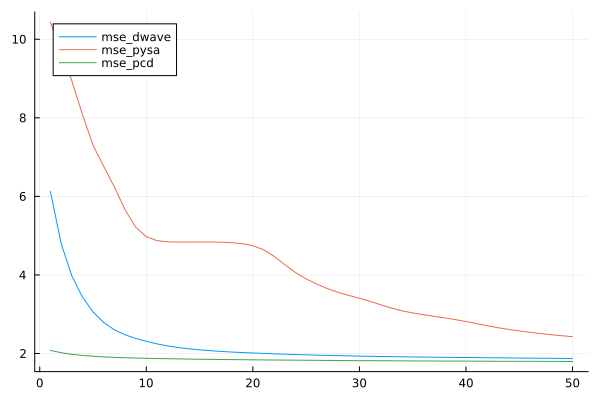

In [49]:
plot(Matrix(df), labels=permutedims(names(df)), legend=:topleft)